In [1]:
from ActiveLearning.dataHandling import MetricsSaver, getFirstEmptyFolder
from yamlParseObjects.yamlObjects import * 
from yamlParseObjects.variablesUtil import *
import logging
from shutil import copyfile
import subprocess
from ActiveLearning.benchmarks import DistanceFromCenter, Branin, Benchmark, Hosaki, SineFunc
from ActiveLearning.Sampling import *
import platform
import shutil
import matplotlib.pyplot as plt 
from enum import Enum
from sklearn import svm
from ActiveLearning.optimizationHelper import GA_Convergence_Sampler, GA_Exploiter, GA_Voronoi_Explorer, ResourceAllocator
from copy import copy, deepcopy

from ActiveLearning.visualization import *
import time 
from datetime import datetime 
import numpy as np 

Generating the samples using CVT method. This may take a while...
Output folder for figures:  ./assets/outputReports/106


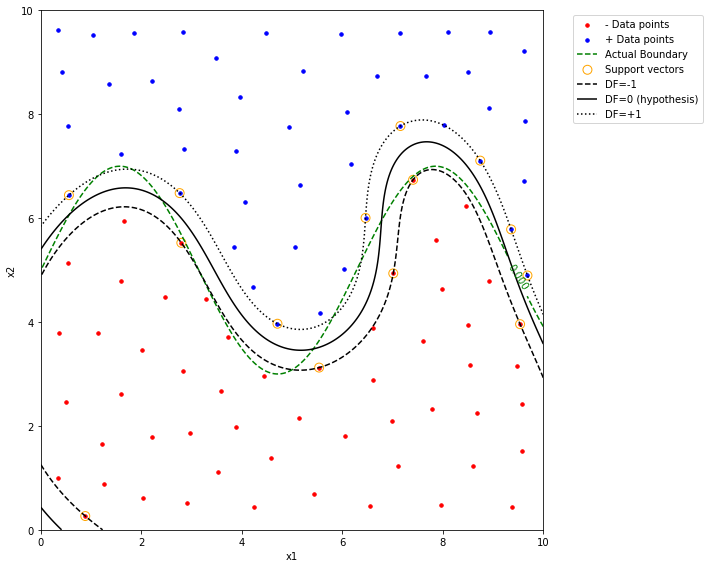

In [2]:

def constraint1(X):
    x1 = X[0]
    x2 = X[1]
    cons = x1-x2 < 2.5
    return cons

def constraint2(X):
    x2=X[1]
    cons = x2 < 3.5
    return cons
consVector = [constraint1, constraint2]

consVector = [] 


# Loading the config files of the process:
simConfigFile = './assets/yamlFiles/adaptiveTesting.yaml'
simConfig = simulationConfig(simConfigFile)
variableFiles = './assets/yamlFiles/varAdaptTest.yaml'
variables = getAllVariableConfigs(yamlFileAddress=variableFiles, scalingScheme=Scale.LINEAR)

# Loading the parameters of the process:
budget = simConfig.sampleBudget
batchSize = simConfig.batchSize
initialSampleSize = simConfig.initialSampleSize

mySpace = SampleSpace(variableList=variables)
dimNames = mySpace.getAllDimensionNames()
initialReport = IterationReport(dimNames)
# Defining the benchmark:
# myBench = DistanceFromCenter(threshold=1.5, inputDim=mySpace.dNum, center = [4] * mySpace.dNum)
# myBench = Branin(threshold=8)
# myBench = Hosaki(threshold = -1)
myBench = SineFunc(threshold=0)
# Generating the initial sample. This step is pure exploration MC sampling:

# Starting time:
initialReport.startTime = datetime.now()
initialReport.setStart()
initialSamples = generateInitialSample(space = mySpace, 
                                        sampleSize = initialSampleSize,
                                        method = InitialSampleMethod.CVT,
                                        checkForEmptiness=False,
                                        constraints=consVector,
                                        resample = True)
initialLabels = myBench.getLabelVec(initialSamples)


# Initial iteration of the classifier trained on the initial samples and their labels:
clf = StandardClassifier(kernel = 'rbf', C = 1000)
clf.fit(initialSamples, initialLabels)
# Adding the samples and their labels to the space: 
mySpace.addSamples(initialSamples, initialLabels)

# # Setting up the location of the output of the process:
outputFolder = f'{simConfig.outputFolder}/{getFirstEmptyFolder(simConfig.outputFolder)}'
# outputFolder = f'{simConfig.outputFolder}/{72}'
print('Output folder for figures: ', outputFolder)
copyfile(simConfigFile, f'{outputFolder}/{os.path.basename(simConfigFile)}')
iterationReportFile = f'{outputFolder}/iterationReport.yaml'
figFolder = setFigureFolder(outputFolder)
sInfo = SaveInformation(fileName = f'{figFolder}/0_InitialPlot', savePDF=True, savePNG=True)

# Visualization of the first iteration of the space with the initial sample:
meshRes = 300
figSize = (10,8)

plotSpace(mySpace, 
        classifier=clf, 
        figsize = figSize, 
        meshRes=meshRes,
        legend = True, 
        showPlot=False,
        saveInfo = sInfo, 
        benchmark = myBench,
        constraints = consVector)

In [3]:
initialReport.stopTime = datetime.now()
initialReport.setStop()
# Defining the exploiter: 
exploiter = GA_Exploiter(space = mySpace, 
                    epsilon = 0.05,
                    batchSize = simConfig.batchSize,
                    convergence_curve=False,
                    progress_bar=False,
                    clf = clf, 
                    constraints = consVector)

In [4]:
converger = GA_Convergence_Sampler(space = mySpace,
                    clf = clf,
                    batchSize = 1,
                    convergence_curve=False,
                    progress_bar=False,
                    constraints = consVector)

In [5]:
prevClf = clf 

In [6]:
exploiterPoints = exploiter.findNextPoints(pointNum=1)

 The best solution found:
 [0.15821041 0.24484429]

 Objective function:
 -0.07241567038987934


In [7]:
sv, label = converger.getFittingSupportVector()
print(sv,label)

[0.88208416 0.26508589] 0


In [9]:
SVs = converger.clf.getSupportVectors(standard = True)

(0, 10)

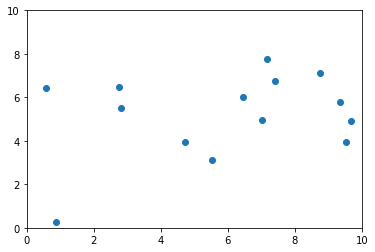

In [11]:
plt.scatter(SVs[:,0], SVs[:,1])
plt.xlim([0,10])
plt.ylim([0,10])

In [12]:
labels = converger.clf.predict(SVs)
labels

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
bestPoints = {}
for idx, sv in enumerate(SVs):
    svLabel = labels[idx]
    svDistance = converger._minDistanceFromOppositeClass(sv,svLabel)
    print(f'Found point for SV # {idx+1}: SV itself: {sv}, Distance: {svDistance}')
    bestPoints[svDistance] = (sv,idx)

Found point for SV # 1: SV itself: [0.88208416 0.26508589], Distance: 0.5324021409362034
Found point for SV # 2: SV itself: [2.79447641 5.52489927], Distance: 0.0958326164253651
Found point for SV # 3: SV itself: [7.40698462 6.73871715], Distance: 0.1065513215539542
Found point for SV # 4: SV itself: [9.53752744 3.95921184], Distance: 0.09486843487152836
Found point for SV # 5: SV itself: [5.53699499 3.12313631], Distance: 0.10594397336395313
Found point for SV # 6: SV itself: [7.01294744 4.93678019], Distance: 0.09938171123171659
Found point for SV # 7: SV itself: [6.46116427 6.00494512], Distance: 0.11970787472757242
Found point for SV # 8: SV itself: [4.70796222 3.96749876], Distance: 0.10215484226588734
Found point for SV # 9: SV itself: [9.68428548 4.89647598], Distance: 0.07760982823317095
Found point for SV # 10: SV itself: [2.76102005 6.48264126], Distance: 0.0958326164253651
Found point for SV # 11: SV itself: [0.55713127 6.44316411], Distance: 0.12025447997013959
Found point 

In [14]:
bestDistance = max(bestPoints.keys())
bestDistance

0.5324021409362034

In [15]:
converger.R = bestDistance / 2
converger.R

0.2662010704681017

In [16]:
fittingSv, fittingIdx = bestPoints[bestDistance]
label = labels[fittingIdx]
converger.sv, converger.label = fittingSv, label

fittingSv, fittingIdx, label


(array([0.88208416, 0.26508589]), 0, 0)

In [17]:
def objFunction(X):
    df = converger.clf.decisionFunction(X.reshape(1,len(X)))
    f = df * label
    distance = np.linalg.norm(np.divide(X - converger.sv,converger.ranges),axis=1)
    if distance > converger.R or f > 0:
        f += 1e6
    return f    

In [18]:
gaModel = converger.getModel()

In [19]:
gaModel.run()

 The best solution found:
 [9.65831415 1.01029759]

 Objective function:
 -0.0


In [21]:
newpoint = gaModel.output_dict['variable']
newpoint

array([9.65831415, 1.01029759])

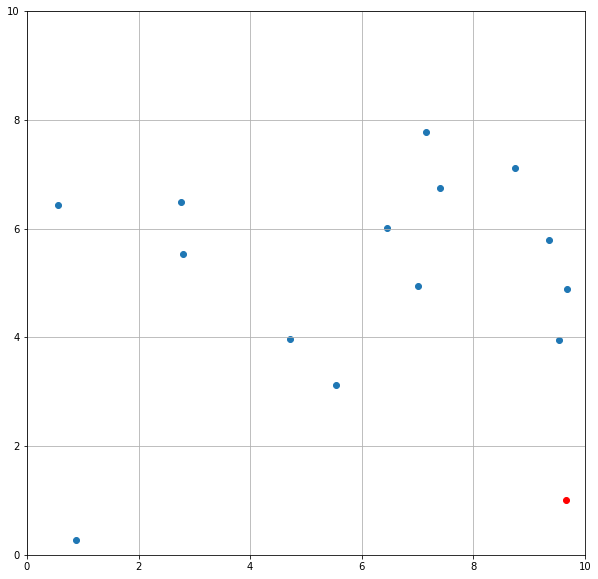

In [27]:
plt.figure(figsize = (10,10))
plt.scatter(SVs[:,0], SVs[:,1])
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid(True)
plt.scatter(newpoint[0], newpoint[1], color = 'r')